# **The Black-Litterman Model - Two different approaches in the estimation of the uncertainty matrix $\Omega$**

The Black-Litterman model is a mathematical model used in finance to overcome the limitations inherent in traditional mean-variance optimization techniques. Developed by Fischer Black and Robert Litterman, this model combines both quantitative and subjective views to derive the expected returns of assets, which is crucial for portfolio optimization.

## Historical Context

Traditional mean-variance optimization (MVO) relies solely on historical data to estimate expected returns, which often leads to unintuitive and highly concentrated portfolios. Black and Litterman introduced their model to integrate market equilibrium with an investor's unique views, thus creating a more diversified and intuitive portfolio.

## Core Principles

- **Market Equilibrium:** The model starts with the assumption that the market is in equilibrium, and the initial expected returns are derived from the market capitalization of the assets.
  
- **Investor or Quantitative Views:** Investors can express their views on the relative or absolute performance of assets. These views are then blended with the market equilibrium returns to arrive at a new set of expected returns.
  - Alternatively, this notebook investigates a fully automated method of weighting quantitative Views.

---

## **Importing all the needed packages**

In [1]:
import numpy as np  # importing the numpy library as np for numerical operations
import pandas as pd  # importing the pandas library as pd for data manipulation and analysis
import requests  # importing the requests library for making HTTP requests
from bs4 import BeautifulSoup  # importing BeautifulSoup from bs4 for web scraping tasks
import yfinance as yf  # importing the yfinance library as yf for fetching financial data
from datetime import datetime, timedelta  # importing datetime and timedelta from datetime for working with dates and times
import matplotlib.pyplot as plt  # importing the pyplot module from matplotlib as plt for plotting data
import seaborn as sns  # importing the seaborn library as sns for statistical data visualization
sns.set_style("whitegrid")  # setting the seaborn style to "whitegrid" for subsequent plots
from pyriskmgmt.fixed_income_models import YieldCurve  # importing YieldCurve from pyriskmgmt.fixed_income_models for fixed income analysis
import scipy.stats as stats  # importing the stats module from scipy for statistical functions

# 1. Data Gathering

## **DJIA Index - Tickers and Weights**

The Dow Jones Industrial Average (DJIA) is a stock market index that measures the performance of 30 large companies listed on stock exchanges in the United States. Established by Charles Dow on May 26, 1896, it's one of the oldest and most-watched indices globally.

In [2]:
# initializing the URL of the Wikipedia page to a variable named 'url'
url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'

# sending a HTTP GET request to the specified URL and storing the response in a variable named 'response'
response = requests.get(url)

# creating a BeautifulSoup object for parsing the HTML content of the page
soup = BeautifulSoup(response.content, 'html.parser')

# finding the table with id 'constituents'
table = soup.find('table', {'id': 'constituents'})

# extracting text from table headers and stripping whitespace
headers = [header.text.strip() for header in table.find_all('th')]

# finding all table rows and skipping the header row
rows = table.find_all('tr')[1:]

# iterating through rows and columns to extract text and strip whitespace
data = []
for row in rows:
    cols = row.find_all('td')
    company_info = cols[0].text.strip().split('\n')
    remaining_cols = [col.text.strip() for col in cols[1:]]
    data.append(company_info + remaining_cols)

# creating a DataFrame from the extracted data and specifying the column headers
DJIA = pd.DataFrame(data, columns=headers[:len(data[0])])  # Adjusting the columns list to match the number of columns in the data

# renaming the DataFrame columns to more descriptive names
columns_names = ["Stock Exchange","Ticker","Sector","Date Added","Notes","Weight"]
DJIA.columns = columns_names

# keeping only the necessary columns for analysis
col_to_keep = ["Ticker","Sector","Weight"]
DJIA = DJIA[col_to_keep]

# removing the '%' character from the 'Weight' column, converting the column to float, and dividing by 100 to convert percentage to decimal
DJIA['Weight'] = DJIA['Weight'].str.rstrip('%').astype(float) / 100

# reordering the DataFrame based on the 'Weight' column in descending order
DJIA = DJIA.sort_values(by='Weight', ascending=False)

# resetting the index of the DataFrame after sorting (optional step)
DJIA.reset_index(drop=True, inplace=True)

# setting the 'Ticker' column as the index of the DataFrame
DJIA.set_index("Ticker", inplace=True)

# displaying the final DataFrame
DJIA

,Sector,Weight
Ticker,,
UNH,Managed health care,0.1029
GS,Financial services,0.0736
HD,Home Improvement,0.0627
AMGN,Biopharmaceutical,0.0548
MCD,Food industry,0.0524
MSFT,Information technology,0.0488
CAT,Construction and mining,0.0452
HON,Conglomerate,0.0417
V,Financial services,0.0416


#### Sanity check on the Weight column

In [3]:
round(np.sum(DJIA.Weight),3)

1.0

## **DJIA Index - Historical Returns For Each Company**

In [4]:
########################################################################
years_back = 1  # initializing the number of years to look back
########################################################################

# calculating the current date
end_date = datetime.now().date()  

# subtracting years_back from the current date to get the start date
start_date = end_date - timedelta(days=years_back*365)  

# extracting ticker values from the DJIA dataframe
Tickers = list(DJIA.index.values)  

# downloading stock data based on the defined tickers and date range
data = yf.download(Tickers, start=start_date, end=end_date)  

# selecting the adjusted close prices from the downloaded data
close_price = data["Adj Close"] 

# calculating percentage change (returns) for the close prices
returns = close_price.pct_change().dropna()  

# filtering returns data to include only those for the defined tickers
returns = returns[Tickers]  

# printing a separator for clarity
print("-"*70)  
# printing a summary message showing number of days and stocks in the returns data
print(f"DJIA Index Components - {returns.shape[0]} days of returns downloaded - {returns.shape[1]} stocks")  
# printing another separator for clarity
print("-"*70)  

# displaying the returns dataframe
returns  

[*********************100%***********************]  30 of 30 completed
----------------------------------------------------------------------
DJIA Index Components - 250 days of returns downloaded - 30 stocks
----------------------------------------------------------------------


,UNH,GS,HD,AMGN,MCD,MSFT,CAT,HON,V,TRV,...,MMM,NKE,MRK,DIS,KO,DOW,CSCO,WBA,VZ,INTC
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-13,0.019902,0.039823,0.008235,0.021182,0.040876,0.037608,0.020279,0.027548,0.036019,0.039897,...,0.048738,0.011863,0.022893,0.034579,0.013239,0.048163,0.034123,0.053538,0.020179,0.043032
2022-10-14,0.006315,-0.023056,-0.022629,-0.001272,-0.014549,-0.024249,-0.027028,-0.019093,-0.011047,-0.013353,...,-0.005514,-0.022443,-0.003352,-0.022661,-0.015930,-0.017422,-0.010096,-0.012184,-0.000550,-0.019304
2022-10-17,0.017052,0.022401,0.017473,0.006326,0.013654,0.039246,0.014647,0.016536,0.014402,0.009186,...,0.002024,0.027641,0.021046,0.030492,0.012914,0.003103,0.027363,-0.007220,0.021990,0.019684
2022-10-18,0.000632,0.023279,0.013510,-0.003202,0.010995,0.004084,0.015210,0.016042,0.010364,0.011954,...,0.018356,-0.003223,0.005206,0.011815,0.013467,0.024746,0.011865,0.003030,-0.002958,-0.020818
2022-10-19,-0.003619,-0.006659,-0.033572,-0.015588,0.006260,-0.008470,0.004685,-0.003336,-0.004060,0.044373,...,-0.015093,-0.012377,-0.014269,0.005179,-0.008505,-0.026951,0.002154,0.008761,-0.013488,0.005025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-05,0.010987,0.006157,-0.002360,-0.001356,-0.013995,0.001254,-0.015960,-0.013589,0.009774,0.008492,...,-0.002159,-0.001043,0.013996,0.018785,-0.048328,-0.024457,-0.007109,-0.004935,0.008878,-0.001113
2023-10-06,0.016621,0.006377,0.003840,0.009016,-0.015898,0.024737,0.020092,0.025775,0.006682,-0.005675,...,0.006490,0.013780,0.002703,0.026358,0.014509,0.008424,0.007160,-0.016682,-0.009790,0.008359
2023-10-09,0.003239,0.000416,0.008674,0.015217,0.006849,0.007823,0.019771,0.010073,-0.002553,0.001902,...,0.007353,-0.002368,0.005968,0.021220,-0.004893,0.010541,0.008793,0.021091,0.019449,-0.003592


## **DJI Index - Price Over Time**

[*********************100%***********************]  1 of 1 completed


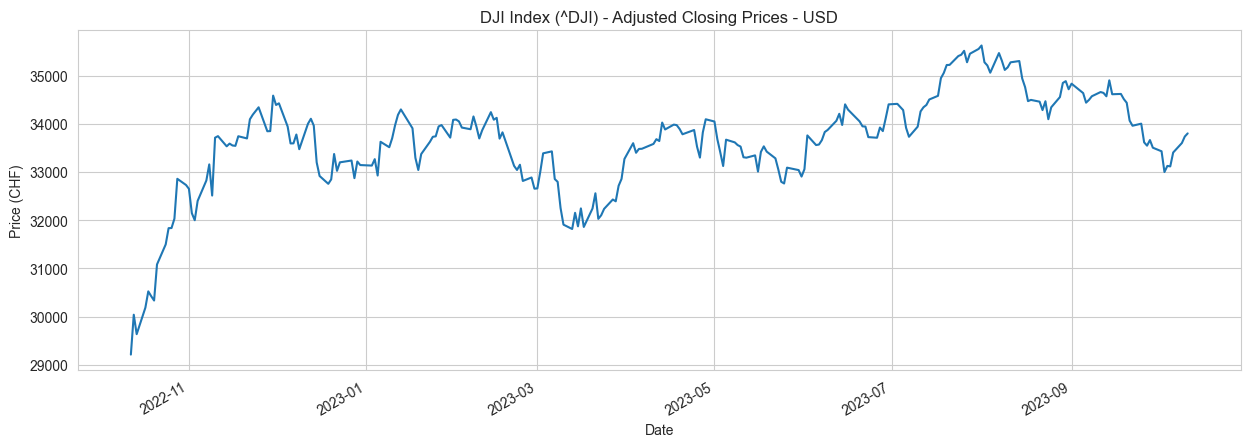

In [5]:
# downloading historical data for DJIA Index
data_djia = yf.download('^DJI', start=start_date, end=end_date)

# extracting the adjusted closing prices
prices_djia = data_djia['Adj Close']

# plotting the adjusted closing prices
plt.figure(figsize=(15,5))
prices_djia.plot()
plt.title('DJI Index (^DJI) - Adjusted Closing Prices - USD')
plt.ylabel('Price (CHF)')
plt.xlabel('Date')
plt.show()

## **DJIA Index - Risk Free Rate and Expected Sharpe/Sortino Ratio**


- YIELD CURVE - from my Python library 'pyriskmgmt'
- https://github.com/GianMarcoOddo/pyriskmgmt 

Fetching Process --->  Done                                                                                                                                                                                                                                                                                                                    


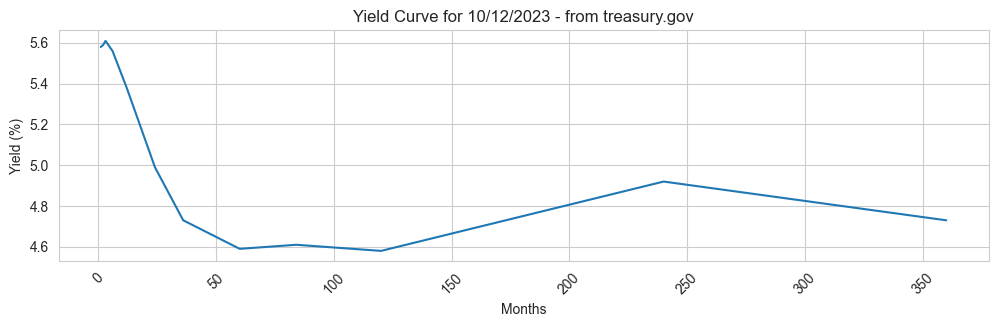

In [6]:
# calling the class YieldCurve from the pyriskmgmt.fixed_income_models module
model = YieldCurve(years_back=1)

# plotting today's Yield Curve
model.PlotYieldCurve()

In [7]:
# retrieving the 10-year annualized interest rate
rf = model.yield_curve_df.iloc[-1][120] / 100
rf

0.0458

## **Sharpe Ratio**

The Sharpe Ratio is a measure of the risk-adjusted return of an investment or portfolio. It tells us how much excess return an investment provides for each unit of risk taken. The formula for the Sharpe Ratio is:

\begin{equation}
\text{Sharpe Ratio} = \frac{\text{Expected Return} - \text{Risk-Free Rate}}{\text{Standard Deviation}}
\end{equation}

Where:
- `Expected Return` is the anticipated annual return of the investment.
- `Risk-Free Rate` is the risk-free rate of return, typically representing the return on a risk-free asset like a government bond.
- `Standard Deviation` is the annualized standard deviation of the investment's returns.

**Explanation:**

- Focus: The Sharpe Ratio primarily measures the overall risk-adjusted performance of an investment, considering both upside and downside volatility.
- Risk Measure: It uses the standard deviation of returns as a measure of total volatility, including both positive and negative returns.
- Interpretation: A higher Sharpe Ratio indicates a better risk-adjusted return, as it means that the investment is providing a higher return for the level of risk taken.

## **Sortino Ratio**

The Sortino Ratio is a variation of the Sharpe Ratio that focuses on downside risk, particularly the standard deviation of negative returns. It provides a measure of the return per unit of downside risk. The formula for the Sortino Ratio is:

\begin{equation}
\text{Sortino Ratio} = \frac{\text{Expected Return} - \text{Risk-Free Rate}}{\text{Downside Standard Deviation}}
\end{equation}

Where:
- `Expected Return` is the anticipated annual return of the investment.
- `Risk-Free Rate` is the risk-free rate of return.
- `Downside Standard Deviation` is the annualized standard deviation of negative returns.

To calculate the `Downside Standard Deviation` for the Sortino Ratio, these steps are necessery:
1. Calculate daily returns for the investment.
2. Select only the negative returns (i.e., returns less than zero).
3. Compute the standard deviation of these negative returns.
4. Annualize the result by multiplying it by the square root of the number of trading days in a year (typically 252).

**Explanation:**

- Focus: The Sortino Ratio is specifically designed to assess the risk-adjusted performance by considering only downside risk or negative returns.
- Risk Measure: It uses the downside standard deviation, which measures the volatility of returns below a certain target or threshold (typically zero or the risk-free rate).
- Interpretation: A higher Sortino Ratio indicates a better risk-adjusted return, with a focus on minimizing the downside risk or the risk of losses. It evaluates how well an investment performs in relation to its potential for negative returns.

---

**Comparison:**

- Focus on Risk: The key difference between the two ratios is their treatment of risk. The Sharpe Ratio considers both upside and downside volatility, while the Sortino Ratio specifically looks at downside risk.
- Volatility Measure: The Sharpe Ratio uses the standard deviation of all returns, including positive and negative ones. In contrast, the Sortino Ratio focuses on the standard deviation of negative returns, which is particularly relevant when investors want to protect against losses.
- Use Case: The Sharpe Ratio is more suitable when investors are concerned about overall volatility and want to assess risk-adjusted returns in a balanced manner. The Sortino Ratio is more appropriate when the primary concern is minimizing downside risk and preserving capital.

In [8]:
# calculating daily returns for the DJIA
djia_rets = prices_djia.pct_change().dropna()

# calculating the expected annual return based on daily returns (252 trading days per year)
expected_return = np.mean(djia_rets) * 252

# calculating the annualized standard deviation of daily returns
std = np.std(djia_rets) * np.sqrt(252)

# SHARPE RATIO

# calculating the Sharpe ratio using the risk-free rate, expected return, and standard deviation
sharpe_ratio = (expected_return - rf) / std

# printing the calculated Sharpe ratio
print(f"Expected Sharpe Ratio for the DJIA Index: {sharpe_ratio:4f}")

# SORTINO RATIO

# filtering only for negative returns
downside_returns = djia_rets[djia_rets < 0]

# std of the negative returns
downside_std = np.std(downside_returns) * np.sqrt(252)

# calculating the Sortino ratio using the risk-free rate and downside standard deviation
sortino_ratio = (expected_return - rf) / downside_std

# printing the calculated Sortino ratio
print(f"Expected Sortino Ratio for the DJIA Index: {sortino_ratio:4f}")

Expected Sharpe Ratio for the DJIA Index: 0.808297
Expected Sortino Ratio for the DJIA Index: 1.423796


# 2. The Black-Litterman Model

## **Procedure Overview**

### 1. Background: Mean-Variance Optimization

- **Objective**: Find portfolio weights to either:
<br>

  - Maximize expected return for a given risk.
<br>

  - Minimize risk for a given expected return.
<br>

- **Issues**: Estimating expected returns is challenging. Small changes in these estimates lead to vastly different portfolio weights, resulting in unstable and potentially non-intuitive portfolios.

---

### 2. The Black-Litterman Solution

- Black-Litterman provides a method to combine:
<br>

  - **Market equilibrium returns**
<br>

  - **Investor's subjective views** on asset returns.
<br>

- By doing so, it shrinks the purely subjective expected returns towards the market equilibrium, producing a more stable set of expected returns.

#### *How it Works:*

- **Compute Market Equilibrium Returns**:
   - These are derived from market weights, **$\delta$** and **$\Sigma$**, acting as a 'neutral' or 'default' prediction.

$$\pi = \delta\Sigma w$$

Where: 

- **$\pi$** represents the Market Equilibrium Returns. It gives us an idea of what returns we might expect given the rest of the inputs in our formula.

- **$\delta$** is a scalar representing the risk aversion coefficient.

- **$\Sigma$** represents the covariance matrix of returns. It's a symmetric matrix that provides the variances of each asset on the diagonal and the covariances between each pair of assets off the diagonal. This matrix is essential for understanding the volatility and co-movement between different assets.

- **$w$** is the vector of market weights. Each component of **$w$** represents the proportion of a given asset in the market portfolio. The sum of all components of **$w$** should be equal to 1, indicating that it's a fully invested portfolio.

> ### *By multiplying the market weights by the covariance matrix and then scaling by the risk aversion coefficient, we get an estimate of the expected returns of the market given current conditions. This is essentially a 'neutral' or 'default' prediction about returns, based on the given inputs.*
   
- **Incorporate Investor's Subjective Views**:
   - This can be absolute views (e.g., UNH will return 10%) or relative views (e.g., UNH will outperform GS by 2%).

<br>
   
- **Combine the Above**:
   - Use a Bayesian approach to combine market equilibrium returns (the prior) with the investor's views to get a posterior set of expected returns.
   - This results in the Black-Litterman expected returns ($\mu^{BL}$) and covariances ($\Sigma^{BL}$).
   
---

### 3. Benefits of Black-Litterman

- Produces more stable portfolio weights.
- Allows for a more intuitive way to incorporate investor views.
- Addresses the over-sensitivity issue in traditional mean-variance optimization.

<br>

---

#### *Importance of Risk Aversion Coefficient **$\delta$**:*

1. **Market Equilibrium:**  
   In the BL model, the market equilibrium return is derived based on the principle that the market portfolio is optimal. The risk aversion coefficient plays a crucial role in translating the market capitalization weights into expected returns.

2. **Investor Views:**  
   Investors may have their own views on the performance of certain assets. The risk aversion coefficient helps in blending these views with the market equilibrium returns in a manner that reflects the relative confidence in the market equilibrium and the investors' views.

3. **Return Adjustments:**  
   A higher value of **$\delta$** indicates that the market is more risk-averse, demanding a higher return for bearing additional risk. This, in turn, impacts the adjusted expected returns generated by the BL model.

<br>

> #### Within the BL framework, **$\delta$** is commonly calculated as follow: 

$$ \delta = \frac{R_m - R_f}{\sigma_m^2}$$

where:
- **$R_m$** is the mean return of the market,
- **$R_f$** is the risk-free rate,
- **$\sigma_m^2$** is the variance of the market returns.

#### *Understanding the Components*

1. **$R_m$ (Mean Return of the Market):**  
   This is the expected return of the market portfolio, which, according to MPT, is the portfolio of all investable assets, weighted by market capitalization.

2. **$R_f$ (Risk-free Rate):**  
   This is the return of a risk-free asset, serving as the baseline return that investors can expect to receive without taking on any additional risk.

3. **$\sigma_m^2$ (Variance of the Market Returns):**  
   This term represents the variability or risk associated with the market portfolio.

#### *Interpretation*

The risk aversion coefficient **$\delta$** quantifies the market's aversion to risk. A higher value of **$\delta$** implies that the market is more risk-averse, demanding a higher return for bearing additional risk. Conversely, a lower value of **$\delta$** suggests a lower level of risk aversion. This coefficient is crucial in the BL model as it helps in adjusting the market equilibrium returns based on the level of risk aversion, thereby aiding in the portfolio optimization process.

In [9]:
delta = round((np.mean(djia_rets) * 252 - rf) / (np.var(djia_rets) * 252), 5)
delta

5.89394

## **Implied Returns - Black Litterman Framework - DJIA Index**

In [10]:
# calculating the annualized covariance matrix from the returns DataFrame by multiplying the daily covariance matrix with 252
Sigma = returns.cov() * 252  

# extracting the portfolio weights from the SMI DataFrame and storing them as a NumPy array
w = DJIA.Weight.values  

# Bl Framework - implied returns function
def implied_returns_func(delta, sigma, w):
    """
    Obtain the implied expected returns by reverse engineering the weights
    Inputs:
    delta: Risk Aversion Coefficient (scalar)
    sigma: Variance-Covariance Matrix (N x N) as DataFrame
        w: Portfolio weights (N x 1) as Series
    Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w)
    return ir 

# calling the function with the specified inputs to compute and return the implied returns
implied_returns = implied_returns_func(delta, Sigma, w) 
implied_returns

UNH     0.083541
GS      0.139614
HD      0.141439
AMGN    0.075232
MCD     0.071307
MSFT    0.141851
CAT     0.151242
HON     0.125391
V       0.111617
TRV     0.094800
CVX     0.105075
JNJ     0.059036
BA      0.135634
AXP     0.150316
WMT     0.064852
PG      0.070581
IBM     0.091938
AAPL    0.149996
CRM     0.147962
JPM     0.126367
MMM     0.144165
NKE     0.145644
MRK     0.062453
DIS     0.156646
KO      0.074222
DOW     0.132209
CSCO    0.101691
WBA     0.120768
VZ      0.061984
INTC    0.163848
dtype: float64

## Implied returns vs Historical returns - DJIA Index

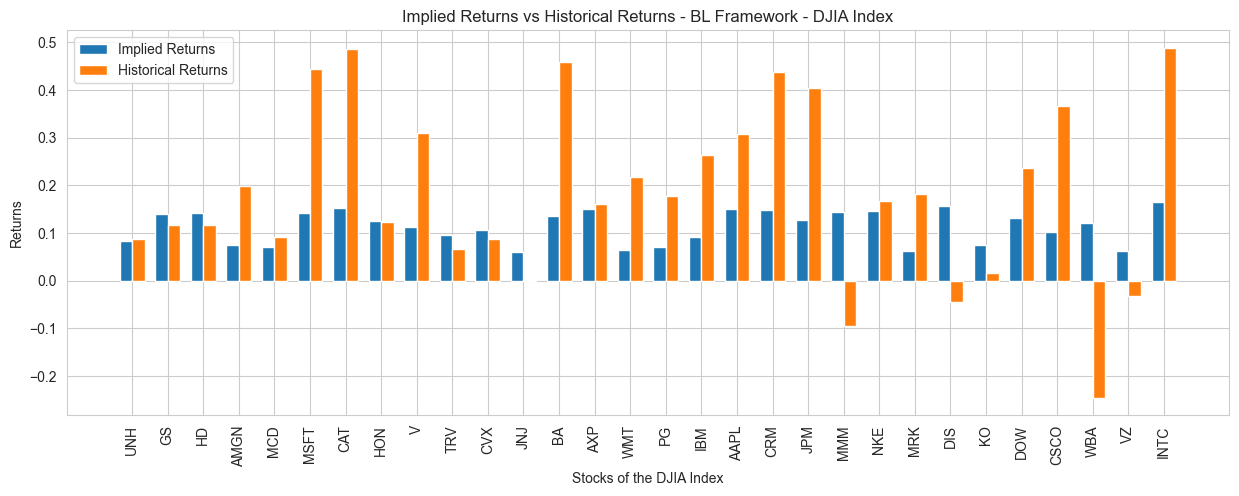

In [11]:
# calculating the annualized mean returns for each asset by finding the mean along axis 0 (across rows/days) and multiplying by 252 
historical_returns = np.mean(returns, axis=0) * 252  

# creating a DataFrame to hold both the implied and historical returns for easy plotting and manipulation
data = pd.DataFrame({'Implied Returns': implied_returns, 'Historical Returns': historical_returns})  

# creating a new figure with specified dimensions (15 units wide by 5 units tall)
plt.figure(figsize=(15,5))  

# generating a sequence of positions for the bars based on the number of assets
positions = np.arange(len(data))  
# setting the width of the bars to be 0.35 units
width = 0.35  

 # plotting the implied returns as a bar chart, shifting the positions to the left by half the width of the bars to make room for the historical returns bars
plt.bar(positions - width/2, data['Implied Returns'], width, label='Implied Returns') 
# plotting the historical returns as a bar chart, shifting the positions to the right by half the width of the bars
plt.bar(positions + width/2, data['Historical Returns'], width, label='Historical Returns')  

# labeling the x-axis as 'Stocks of the SMI'
plt.xlabel('Stocks of the DJIA Index')  
# labeling the y-axis as 'Returns'
plt.ylabel('Returns')  
 # providing a title for the plot
plt.title('Implied Returns vs Historical Returns - BL Framework - DJIA Index') 
 # setting the positions and labels of the x-axis ticks, and rotating the labels by 90 degrees for better readability
plt.xticks(positions, data.index, rotation = 90) 
 # displaying a legend to differentiate between implied and historical returns
plt.legend() 

# rendering the plot to the screen
plt.show() 

## **Black-Litterman Model Implementation Explanation - Step by Step**

The `bl` function implements the Black-Litterman (BL) model, melding a prior set of expected returns with an investor's views to provide a posterior set of expected returns, which are then used to determine optimal asset allocations based on a specified objective. 

> - Here's a detailed breakdown of the function and its parameters:

- **Parameters**:
    - `implied_returns`: (N x 1) The market implied returns.       
    - `sigma`: (N x N) The covariance matrix of asset returns - historical 
    - `P`: (K x N) The matrix linking the views (`Q`) and the assets. 
    - `Q`: (K x 1) The vector of views.
    - `tau`: A scaling factor for the covariance matrix.
    - `delta`: The market risk aversion scalar.
    - `omega_type`: The uncertainty matrix of the views, with estimation methods of "Rachev", or "Scherer".
    - `objective`: The optimization objective, either "MaxSharpe" or "MinVar".
    - `conf_levels`, `lower_limits`: (K x 1) Parameters needed if the "Rachev" method is chosen for omega estimation.
    - `unexplained_variances`: (K x 1) Parameter needed if the "Scherer" method is chosen for omega estimation.
    - `r_squared_s`: (K x 1) Parameter needed if the "Scherer" method is chosen for omega estimation.

    <br>

    > ### K is the number of views and N is the number of assets

## **Omega Estimation**

Estimating **$\Omega$**, the uncertainty matrix associated with the views, is a critical step, and is often cited as the most challenging part of the BL model. 
- Two methods are provided for this estimation: "Rachev", and "Scherer".

#### Rachev **$\Omega$**

The approach proposed by Rachev et al. (2008) and Scherer (2010) for the esimation of **$\Omega$** is coded when `omega_type` = "Rachev", giving room for the investor to specify confidence in views. In this framework, the implied variances of views are derived from the investor's judgement.

The Black-Litterman model assumes that the returns of the views-portfolios are independently normally distributed. Under this approach, an investor is asked to characterize the normal distribution of each view. This includes specifying the expected return of the view, an interval within which the returns are expected to lie, and a level of confidence that the returns will actually lie within this interval.

Given:
- **$c_k$** as the investor's confidence in the **$k$** th view
- **$q_k$** as the expected return of the **$k$** th view,
- **$l_k$** as the investor-specified lower limit for the **$k$** view,

The formula for estimating an element **$\omega_{k,k}$** of **$\Omega$** is given by:

$$\omega_{k,k} = \frac{(l_k - q_k)^2}{Z_{\alpha_k}}$$

where 

- **$\alpha_k$** is 1 - **$c_k$**

- **$Z_{\alpha_k}$** is the **$\alpha_k$** quantile of the standard normal distribution.

The formula given calculates the uncertainty associated with a view by taking the square of the difference between the lower limit and the expected return, and then dividing this by a value derived from the standard normal distribution, based on the investor's confidence level. This value from the standard normal distribution is the quantile corresponding to the level of confidence the investor has in the view.

The logic behind this formula is to quantify the uncertainty or variance of a view based on both the investor's judgement about the expected return and their confidence in that judgement. By incorporating the investor's confidence level and judgement about the expected return, this approach provides a way to adjust the level of uncertainty associated with each view in a way that's aligned with the investor's own assessments and beliefs.

---


#### Scherer **$\Omega$**

if the "Scherer" method for `omega_type` is selected the code proposes an alternative method for estimating the uncertainty matrix **$\Omega$** when the views are derived from a **quantitative forecasting model**. In this scenario, the diagonal elements **$\omega_{k,k}$** of **$\Omega$** are set to the unexplained variances of the respective forecasting model. The formula for **$\omega_{k,k}$** and **$\Omega$** is given by:

$$
\omega_{k,k} = \sigma_k^2(1 - R_k^2)
$$

<br>

$$
\Omega = \begin{pmatrix}
\sigma_1^2(1 - R_1^2) & 0 & \cdots & 0 \\
0 & \sigma_2^2(1 - R_2^2) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_k^2(1 - R_k^2)
\end{pmatrix}
$$


#### *Scherer Method Explanation*

2. **$\sigma_k^2$**  represents the variance of the forecast error for the **$k$** th view. It's a measure of the dispersion or spread of the forecast errors.

3. **$R_k^2$** is the R-squared value for the **$k$** th, indicating the proportion of variance in the asset returns that is explained by the forecasting model. **$R_k^2$** values range from 0 to 1, with higher values indicating better explanatory power of the model.


In this method, the unexplained variance for each view is computed using the formula **$\omega_{k,k} = \sigma_k^2(1 - R_k^2)$**, and these values are placed on the diagonal of the uncertainty matrix **$\Omega$** to form a diagonal matrix.

---

## **Scaling The Covariance Matrix**

Then, the historical covariance matrix **$\Sigma$** is scaled by the scalar **$\tau$**. This scaling is a crucial step as it represents the uncertainty in the prior market equilibrium excess returns. In the Black-Litterman framework, **$\tau$** is a scalar that helps in blending the subjective views with the market equilibrium returns. The choice of **$\tau$** influences the extent to which the investor's views affect the final posterior returns. A smaller value of **$\tau$** will result in lesser shrinkage towards the market equilibrium, allowing the investor's views to have a more significant impact on the posterior returns, and vice versa.


## **Computing Posterior Expected Returns: **$mu_{BL}$****

The formula for computing the posterior expected returns based on the provided code is given by:


$$mu_{BL} = \pi + \Sigma_{\text{scaled}} P^T \left( P \Sigma_{\text{scaled}} P^T + \Omega \right)^{-1} (Q - P \pi)$$

Where:
- **$\pi$** is the vector of market implied returns.
- $\Sigma_{\text{scaled}}$ is the covariance matrix scaled by the scalar **$tau$**.
- **$P$** is the matrix linking the assets to the views.
- **$Q$** is the vector of views.
- **$\Omega$** is the uncertainty matrix of the views.

#### *Posterior Expected Returns Explanation*

The formula for the Black-Litterman posterior expected returns **$mu_{BL}$** starts with the market implied returns **$\pi$**, and then adjusts these returns based on the investor's views **$Q$**. 

- The adjustment is mediated by several terms:

- The term $$P \Sigma_{\text{scaled}} P^T + \Omega$$ represents the total uncertainty, combining the uncertainty from the market covariance matrix with the uncertainty of the views. This term essentially encapsulates the total variance when both market and views uncertainties are considered.

- The term $$(Q - P \pi)$$ represents the difference between the investor's views and the market implied returns projected onto the view space. This differential quantifies how much the investor's views deviate from the market expectations.

- The entire expression  $$\Sigma_{\text{scaled}} P^T \left( P \Sigma_{\text{scaled}} P^T + \Omega \right)^{-1} (Q - P \pi)$$ computes the adjustment to the market implied returns, based on the investor's views and the total uncertainty. This expression calculates the amount by which the market implied returns should be adjusted to accommodate the investor's views while considering the associated uncertainties.

<br>

## **Computing Posterior Covariance Matrix: $\Sigma_{BL}$**

The posterior covariance matrix is computed, taking into account the scaled covariance matrix and the estimated uncertainty matrix `omega`.
It incorporates both the market's estimate of covariance and the additional uncertainty introduced by the investor's views. This matrix is crucial for portfolio optimization, as it reflects the updated beliefs about the assets' relationships after considering the investor's views.

The formula for computing the posterior covariance matrix **$\Sigma_{BL}$** is given by:

$$\Sigma_{BL} = \Sigma_{\text{scaled}} - \Sigma_{\text{scaled}} P^T \left( P \Sigma_{\text{scaled}} P^T + \Omega \right)^{-1} P \Sigma_{\text{scaled}}$$

Where:
- **$\Sigma_{\text{scaled}}$** is the covariance matrix scaled by the scalar \( \tau \).
- **$P$** is the matrix linking the assets to the views.
- **$\Omega$** is the uncertainty matrix of the views.

#### *Posterior Posterior Covariance Matrix Explanation*

The formula for **$\Sigma_{BL}$** can be dissected into several components:

- The term $$P \Sigma_{\text{scaled}} P^T + \Omega$$ represents the total uncertainty, combining the uncertainty from the market covariance matrix with the uncertainty of the views. This term is the same as in the formula for **$mu_{BL}$**, encapsulating the total variance when both market and views uncertainties are considered.

- The expression $$\Sigma_{\text{scaled}} P^T \left( P \Sigma_{\text{scaled}} P^T + \Omega \right)^{-1} P \Sigma_{\text{scaled}}$$ computes the reduction in uncertainty due to the incorporation of the investor's views. This term essentially calculates how much the covariance matrix is adjusted based on the views.

- Finally, **$\Sigma_{\text{scaled}}$** minus the above expression gives the updated posterior covariance matrix, which reflects the new beliefs about asset covariance after considering the investor's views.

## **Optimizing Asset Weights**

Based on the new **$mu_{BL}$** and **$\Sigma_{BL}$**, asset weights are optimized based on the specified objective. If "MaxSharpe" is chosen, the weights are optimized to maximize the Sharpe ratio. If "MinVar" is chosen, the weights are optimized to minimize portfolio variance.

## **Returning Asset Weights**
The function returns the optimized asset weights.

---
# **The Main Function - Black Litterman Model**
---

In [12]:
def bl(implied_returns,sigma, P, Q, tau, delta, omega_type = "Rachev", objective = "MaxSharpe",
       conf_levels = None, lower_limits = None, unexplained_variances = None, r_squared_s = None):
    
    """
    This function computes the Black-Litterman portfolio weights based on market implied returns,
    a covariance matrix, a matrix linking views to assets, a vector of views, and various other parameters.

    Parameters:
    - `implied_returns` (N x 1): The market implied returns from the BL framework
    - `sigma` (N x N): The covariance matrix of asset returns - historical.
    - `P` (K x N): The matrix linking the views (`Q`) and the assets.
    - `Q` (K x 1): The vector of views.
    - `tau`: A scaling factor for the covariance matrix.
    - `delta`: The market risk aversion scalar.
    - `omega_type`: The type of uncertainty matrix of the views, with estimation methods of "Rachev", or "Scherer".
    - `objective`: The optimization objective, either "MaxSharpe" or "MinVar".
    - `conf_levels` (K x 1): Parameters needed if the "Rachev" method is chosen for omega estimation.
    - `lower_limits` (K x 1): Parameters needed if the "Rachev" method is chosen for omega estimation.
    - `unexplained_variances` (K x 1): Parameter needed if the "Scherer" method is chosen for omega estimation.
    - `r_squared_s` (K x 1): Parameter needed if the "Scherer" method is chosen for omega estimation.
    
    Returns:
    - The Black-Litterman portfolio weights reshaped to a single-column vector.
    """

    # asserting that the 'objective' parameter value is either 'MaxSharpe' or 'MinVar'.
    assert objective in ["MaxSharpe", "MinVar"], "the 'objective' parameter must be either 'MaxSharpe' or 'MinVar'"
    # asserting that the 'omega_type' parameter value is either 'Peterson', 'Rachev', or 'Scherer'.
    assert omega_type in ["Rachev","Scherer"], "the 'omega_type' parameter must be either 'Rachev' or 'Scherer'"

    # checking if the 'omega_type' is 'Rachev' to compute Omega using the Rachev method.
    if omega_type == "Rachev":
        # ensuring that 'conf_levels' and 'lower_limits' are provided and have correct dimensions.
        assert conf_levels is not None and lower_limits is not None, "conf_levels and lower_limits must be provided for Rachev omega"
        assert len(conf_levels) == len(lower_limits) == len(Q), "conf_levels and lower_limits must have the same length as Q"
        
        omega_diag = np.zeros(len(Q))  # initializing an empty diagonal for Omega.

        # filling the diagonal of Omega according to the Rachev formula.
        for k in range(len(Q)):
            omega_diag[k] = ((lower_limits[k] - Q[k]) / stats.norm.ppf(1 - (conf_levels[k])))**2
        
        omega = np.diag(omega_diag)  # forming Omega with the computed diagonal values.

    # checking if the 'omega_type' is 'Scherer' to compute Omega using the Scherer method.
    elif omega_type == "Scherer":
        # ensuring that 'unexplained_variances' and 'r_squared_s' are provided and have correct dimensions.
        assert unexplained_variances is not None and r_squared_s is not None, "'unexplaind_variances' and 'r_squared_s' must be provided for Scherer omega"
        assert len(unexplained_variances) == len(r_squared_s) == len(Q), "unexplained_variances and 'r_squared_s' must have the same length as Q"
        
        # filling the diagonal of Omega according to the Rachev formula.
        omega_diag = np.zeros(len(Q))
        for j in range(len(omega_diag)): 
            omega_diag[j] = unexplained_variances[j] * (1-r_squared_s[j])

        omega = np.diag(omega_diag) # forming Omega with the computed diagonal values.

    # scaling the sigma matrix by tau.
    sigma_scaled = tau * sigma 

    # computing the Black-Litterman expected returns 'mu_bl'.
    mu_bl = implied_returns + np.dot(
        np.dot(sigma_scaled, P.T),
        np.dot(
            np.linalg.inv(
                np.dot(
                    np.dot(P, sigma_scaled),
                    P.T
                ) + omega
            ),
            (Q - np.dot(P, implied_returns))))
    
    # computing the Black-Litterman covariance matrix 'sigma_bl'.
    sigma_bl = sigma + sigma_scaled - np.dot(
        np.dot(
            np.dot(sigma_scaled, P.T), 
            np.linalg.inv(
                np.dot(
                    np.dot(P, sigma_scaled), 
                    P.T
                ) + omega)), np.dot(P, sigma_scaled))

    # checking if the objective is to maximize the Sharpe Ratio.
    if objective == "MaxSharpe":
        inv_sigma = np.linalg.inv(sigma_bl)  # computing the inverse of sigma_bl.
        bl_weights = np.dot(inv_sigma, mu_bl) / delta  # computing the weights to maximize the Sharpe Ratio.

    # checking if the objective is to minimize variance.
    elif objective == "MinVar":
        inv_sigma = np.linalg.inv(sigma_bl)  # computing the inverse of sigma_bl.
        ones = np.ones_like(mu_bl)  # creating a vector of ones with the same dimensions as 'mu_bl'.
        bl_weights = np.dot(inv_sigma, ones) / np.dot(ones.T, np.dot(inv_sigma, ones))  # computing the weights to minimize variance.

    # returning the Black-Litterman weights reshaped to a single-column vector.
    return bl_weights.reshape(-1) 

> ### NOTE: From now we will use the objective parameter ="MaxSharpe", but the cells below work also with the objective parameter = "MinVar" mode.

In [13]:
objective = "MaxSharpe"
objective

'MaxSharpe'

## **Consideration on **$\tau$****

In [14]:
tau = 0.02
tau

0.02

> ### As previously stated, in the Black-Litterman (BL) model, τ (tau) is a scalar that moderates the extent to which investors' views are incorporated compared to the market equilibrium returns. A smaller τ value like 0.02 implies more weight is given to the investors' views, while a larger τ value places more weight on the market equilibrium returns. Varying τ impacts the blend of market equilibrium and investor views in the model's output, affecting the resulting asset allocations. 

## *For this example we are going to use a value of τ (tau) of 0.02*

---

# Views, Confidence and Lower Limits - First approach - Rachev **$\Omega$**

### 1. GS will outperform AMGN by 8%
**Belief**: Goldman Sachs (GS) may be expected to outperform Amgen (AMGN) due to positive factors such as strong financial performance, potential for growth in the financial sector, or market conditions favoring financial companies.

**Example**: During periods of economic growth, financial institutions like GS often benefit from increased lending activity and investment opportunities, which can lead to higher returns. Additionally, if GS has recently reported strong quarterly earnings or has a favorable outlook, it might support the belief that it could outperform AMGN in the near term.

**Confidence Level (90%)**: This level of confidence might be derived from historical performance trends, recent financial reports, and favorable market conditions for financial sector companies. It implies a high degree of certainty in the belief that GS will outperform AMGN.

**Lower Limit (-1%)**: The lower limit represents the worst-case scenario within the expected range of outcomes. In this case, it suggests that even in less favorable conditions, the performance of GS is not expected to fall more than 1% below that of AMGN.


### 2. MMM will earn 6% more than INTC
**Belief**: 3M (MMM) may be expected to earn more than Intel (INTC) due to factors like innovation, diversified product lines, or strong demand for its products.

**Example**: If MMM has recently launched innovative products that are gaining market share or has a history of research and development leading to profitable inventions, this could support the belief. Furthermore, if INTC is facing challenges or increased competition in the semiconductor industry, it might explain the expected performance difference.

**Confidence Level (80%)**: This confidence level could be based on MMM's track record of innovation and diversified product lines, as well as the current market demand for its products. It indicates a strong, but not absolute, belief in MMM's potential to outperform INTC.

**Lower Limit (-3%)**: The lower limit here indicates a buffer for potential underperformance. It suggests that in adverse conditions, MMM's earnings might drop to 3% below INTC's, reflecting a level of caution in the analysis.


### 3. MSFT will beat HON by 4%
**Belief**: Microsoft (MSFT) may be expected to outperform Honeywell (HON) due to factors such as strong cloud computing services, software dominance, or growth potential.

**Example**: If MSFT is consistently growing its Azure cloud platform, signing lucrative contracts, or acquiring companies in strategic areas, it could indicate strength in the technology sector. Conversely, if HON faces challenges in its industrial operations or reports weaker financial results, it may support the belief that MSFT will perform better.

**Confidence Level (75%)**: The confidence here might be driven by MSFT's strong position in the cloud computing and software markets, alongside a solid financial performance. It reflects a moderate to high level of certainty in MSFT's ability to outperform HON.

**Lower Limit (-2.5%)**: This limit suggests a scenario where MSFT's performance could fall 2.5% below HON's, possibly due to unexpected market changes or operational challenges, providing a cushion for potential downside risks.


### 4. AAPL will earn 8% more than IBM
**Belief**: Apple (AAPL) is expected to earn significantly more than IBM due to factors like product innovation, consumer demand, or brand strength.

**Example**: If AAPL launches highly anticipated products like a new iPhone or experiences strong sales of existing products, it may drive higher earnings. Additionally, if IBM is undergoing restructuring or faces competition in its traditional business lines, it could explain the expected performance difference.

**Confidence Level (95%)**: The high confidence level could be attributed to AAPL's consistent innovation, strong brand loyalty, and robust financial health. It suggests a very high level of belief in AAPL's potential to outperform IBM.

**Lower Limit (-0.5%)**: The very narrow lower limit indicates a strong belief that AAPL will outperform IBM, with minimal room for underperformance, reflecting a bullish outlook on AAPL.


### 5. PG will earn 9%
**Belief**: Procter & Gamble (PG) is expected to earn a 9% increase in earnings due to its strong brand portfolio, diversified range of consumer products, and steady market demand. 

**Example**: PG's well-established brands like Tide, Pampers, and Gillette provide a stable revenue stream, while its continuous investment in R&D may lead to innovative products driving further growth. The consistent demand for consumer goods, even in economic downturns, can also contribute to its earning potential.

**Confidence Level (98%)**: The extremely high confidence level might be due to PG's stable and diversified product portfolio, which historically provides steady earnings. It represents a very strong belief in PG's earning potential based on its market position and financial stability.

**Lower Limit (-5%)**: This lower limit reflects a cautious stance, allowing for a significant downside before the belief is invalidated. It may account for unforeseen market conditions or operational challenges that could impact PG's performance.


Subjective Views - Objective: 'MaxSharpe'
-----------------------------------------------------------------
1. GS will outperform AMGN by 8%
2. MMM will earn 6% more than INTC
3. MSFT will beat HON by 4%
4. AAPL will earn 8% more than IBM
5. PG will earn 9%
-----------------------------------------------------------------
View's Confidence Levels
[0.9  0.8  0.75 0.95 0.98]
View's Lower Limits
[-0.01  -0.03  -0.025 -0.005 -0.05 ]
-----------------------------------------------------------------


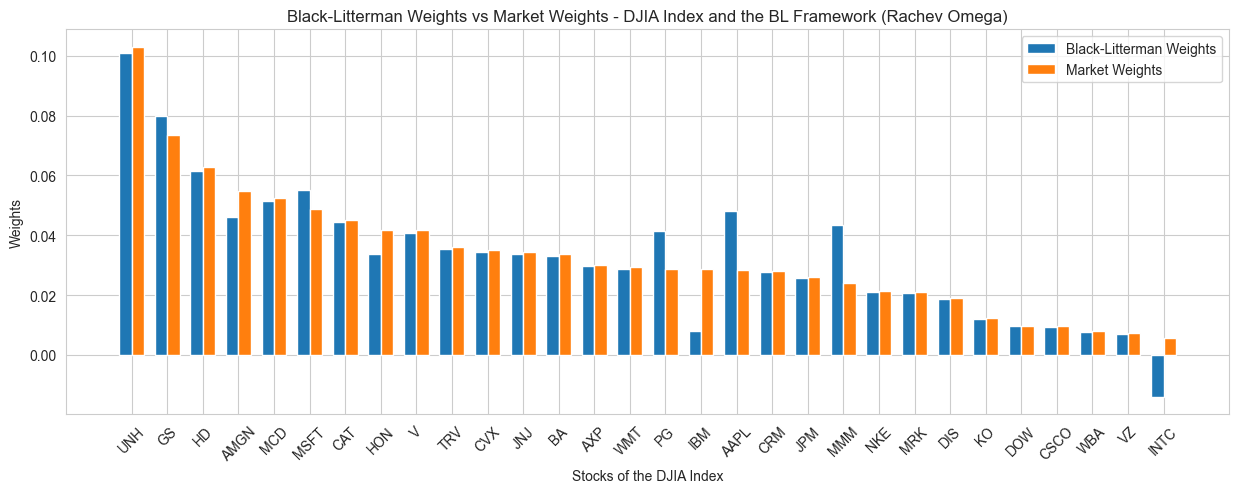

In [15]:
# defining the matrix P that represents views on relative performances between companies
P = np.array([
    [0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #first view
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1], #second view
    [0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #third view
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #fourth view
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]  #fifth view
    )

# defining the vector Q that represents the expected relative return based on the views
Q = np.array([0.08, 0.06, 0.04, 0.08, 0.09]).reshape(-1,1)

# defining confidence levels for each of the views
conf_levels = np.array([0.9, 0.8, 0.75, 0.95, 0.98]).reshape(-1,1)

# defining the lower limit on expected returns for the views
lower_limits = np.array([-0.01, -0.03, -0.025, -0.005, -0.05]).reshape(-1,1)

# reshaping the implied returns to be a column vector
implied_rets = implied_returns.values.reshape(-1,1)

# calculating the Black-Litterman weights based on views, implied returns, lower_limits and conf_levels
BL_Weight = bl(implied_rets,Sigma, P, Q, tau, delta, omega_type= "Rachev", objective = objective,
               lower_limits= lower_limits, conf_levels= conf_levels)

# creating a dataframe to compare the calculated BL weights with the initial weights
diff = pd.DataFrame({ "BL_Weight": BL_Weight, "InitialWeight": w}, index=DJIA.index)

# initializing a new figure for plotting with given dimensions
plt.figure(figsize=(15, 5))

# generating a sequence of positions for plotting the bars
positions = np.arange(len(diff))

# setting the width of bars in the bar chart
width = 0.35

# plotting the BL weights as a bar chart with positions shifted to the left
plt.bar(positions - width/2, diff['BL_Weight'], width, label='Black-Litterman Weights')

# plotting the initial weights as a bar chart with positions shifted to the right
plt.bar(positions + width/2, diff['InitialWeight'], width, label='Market Weights')

# setting the x-axis label
plt.xlabel('Stocks of the DJIA Index')

# setting the y-axis label
plt.ylabel('Weights')

# providing a title for the plot
plt.title('Black-Litterman Weights vs Market Weights - DJIA Index and the BL Framework (Rachev Omega)')

# setting tick positions and labels for the x-axis and rotating them for better readability
plt.xticks(positions, diff.index, rotation=45)

# displaying the legend to differentiate between BL weights and initial weights
plt.legend()

# printing the views on companies' performance
print(f"Subjective Views - Objective: '{objective}'")
print("-"*65)
print("1. GS will outperform AMGN by 8%")
print("2. MMM will earn 6% more than INTC")
print("3. MSFT will beat HON by 4%")
print("4. AAPL will earn 8% more than IBM")
print("5. PG will earn 9%")
print("-"*65)

# printing the confidence levels
print("View's Confidence Levels")
print(conf_levels.reshape(-1))
# printing the lower limits for expected returns
print("View's Lower Limits")
print(lower_limits.reshape(-1))
print("-"*65)

# rendering the plot to be visible
plt.show()

In [16]:
diff["DIFF"] = round(diff["BL_Weight"] - diff["InitialWeight"],5)
diff

,BL_Weight,InitialWeight,DIFF
Ticker,,,
UNH,0.100882,0.1029,-0.00202
GS,0.079828,0.0736,0.00623
HD,0.061471,0.0627,-0.00123
AMGN,0.046054,0.0548,-0.00875
MCD,0.051373,0.0524,-0.00103
MSFT,0.055159,0.0488,0.00636
CAT,0.044314,0.0452,-0.00089
HON,0.033566,0.0417,-0.00813
V,0.040784,0.0416,-0.00082


# Automated Quantitative Approach in the Black Litterman Framework - Scherer **$\Omega$**

Let's now consider an example in which your quantitative model produced the following result: 

| Pair | Expected Outperformance | $\sigma_r$ | $R^2$ |
|------|-------------------------|------------|-------|
| WBA vs PG | 7% | 0.002 | 0.45 |
| UNH vs HD | 3% | 0.025 | 0.75 |
| MRK vs NKE | 8% | 0.01  | 0.65 |
| KO vs V    | 4% | 0.03 | 0.45 |

### These values can constanly calculated and automatized using a **Quantitative** model such as: 

- CAPM (Capital Asset Pricing Model): May be used if analyzing expected returns based on market beta.
- Arbitrage Pricing Theory (APT): If multiple factors are driving the expected returns.
- Multi-Factor Models: Like the Fama-French model, if there are multiple factors affecting the returns.
- Statistical Arbitrage Models: Which often analyze pairs of assets for mean-reversion strategies.
- Machine Learning Models: Such as regression models, random forests, or neural networks, if the data is derived from a predictive model.

<br>

> ### In this example we will take $Q$, $\sigma_r$ and $R^2$ as taken, since the primary focus is to implement those upon the Black-Litterman Framework

Quantitative Views - Objective: 'MaxSharpe'
-----------------------------------------------------------------
| Pair       | Expected Outperformance |  var_res   |  R^2  |
|----------- |-------------------------|------------|-------|
| WBA vs PG  | 7%                      | 0.002      | 0.45  |
| UNH vs HD  | 3%                      | 0.025      | 0.75  |
| MKR vs NKE | 8%                      | 0.002      | 0.65  |
| KO vs V    | 4%                      | 0.005      | 0.45  |
-----------------------------------------------------------------


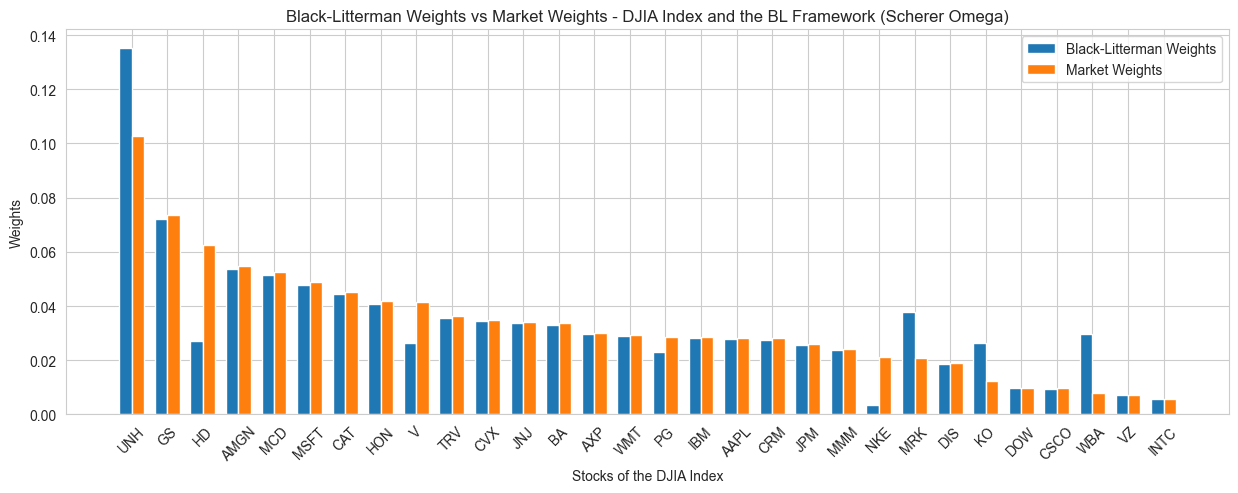

In [17]:
# defining the matrix P which represents the views on relative performances between companies
P = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # first view
    [1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # second view
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 1, 0, 0],  # third view
    [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  # fourth view
])

# defining a column vector Q with the expected returns of the views
# this will be the output of the statistical model
Q = np.array([0.07, 0.03, 0.08, 0.04]).reshape(-1,1)

# defining a column vector for the variances of unexplained returns for each view
# this will be the output of the statistical model
unexplained_variances = np.array([0.02,0.025,0.01,0.03]).reshape(-1,1)

# defining a column vector for the R squared values for each view
# this will be the output of the statistical model
r_squared_s = np.array([0.45,0.75,0.65,0.45]).reshape(-1,1)

# reshaping the implied returns vector to be a column vector
implied_rets = implied_returns.values.reshape(-1,1)

# calculating the Black-Litterman weights based on views, implied returns, unexplained_variances and r_squared_s
BL_Weight = bl(implied_rets,Sigma, P, Q, tau, delta, omega_type= "Scherer", objective = objective,
            unexplained_variances= unexplained_variances, r_squared_s=r_squared_s)

# creating a dataframe to compare the calculated BL weights with the initial weights
diff = pd.DataFrame({"BL_Weight": BL_Weight, "InitialWeight": w}, index=DJIA.index)

# setting the figure size for the plot
plt.figure(figsize=(15, 5))

# defining the positions for the bars in the bar plot
positions = np.arange(len(diff))

# defining the width of the bars
width = 0.35

# plotting the bars for Black-Litterman weights
plt.bar(positions - width/2, diff['BL_Weight'], width, label='Black-Litterman Weights')

# plotting the bars for initial weights
plt.bar(positions + width/2, diff['InitialWeight'], width, label='Market Weights')

# setting the x-axis label
plt.xlabel('Stocks of the DJIA Index')

# setting the y-axis label
plt.ylabel('Weights')

# setting the title of the plot
plt.title('Black-Litterman Weights vs Market Weights - DJIA Index and the BL Framework (Scherer Omega)')

# setting the x-ticks labels and rotating them for better readability
plt.xticks(positions, diff.index, rotation=45)

# adding a legend to the plot
plt.legend()

# printing the textual representation of the views
print(f"Quantitative Views - Objective: '{objective}'")
print("-"*65)
print(
"""| Pair       | Expected Outperformance |  var_res   |  R^2  |
|----------- |-------------------------|------------|-------|
| WBA vs PG  | 7%                      | 0.002      | 0.45  |
| UNH vs HD  | 3%                      | 0.025      | 0.75  |
| MKR vs NKE | 8%                      | 0.002      | 0.65  |
| KO vs V    | 4%                      | 0.005      | 0.45  |""")
print("-"*65)

# displaying the plot
plt.show()

In [18]:
diff["DIFF"] = round(diff["BL_Weight"] - diff["InitialWeight"],5)
diff

,BL_Weight,InitialWeight,DIFF
Ticker,,,
UNH,0.135305,0.1029,0.03241
GS,0.072157,0.0736,-0.00144
HD,0.027048,0.0627,-0.03565
AMGN,0.053725,0.0548,-0.00107
MCD,0.051373,0.0524,-0.00103
MSFT,0.047843,0.0488,-0.00096
CAT,0.044314,0.0452,-0.00089
HON,0.040882,0.0417,-0.00082
V,0.026376,0.0416,-0.01522
